In [13]:
import pickle
import pandas as pd

import sys, os
from pathlib import Path
# signalfuncなどのある親ディレクトリのパスを取得,これはJupyter系特有の書き方
current_dir = os.path.join(Path().resolve())
# モジュールのあるパスを追加
sys.path.append(str(current_dir) + '/../')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import ml_modules as mm

In [14]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df_train_data = pd.read_csv('../data/wine_train.csv')
df_train_data = pd.get_dummies(df_train_data)

x = df_train_data[list(set(df_train_data.columns)-set(['type_W','type_R','quality','quality_range']))]
# y = df_train_data['quality_range']
y = df_train_data['quality']

In [3]:
filename_lr = '../model/add_prob_pca_rm_multico_lr_model.pickle'
filename_svc = '../model/add_prob_pca_rm_multico_svc_model.pickle'

In [4]:
with open(filename_lr, mode='rb') as fp:
    lr = pickle.load(fp)
with open(filename_svc, mode='rb') as fp:
    svc = pickle.load(fp)   

In [5]:
filename_voting = '../model/lda_rm_multico_voting_model.pickle'
filename_GBC = '../model/logloss_pca_rm_multico_GBC_model.pickle'
filename_KNN = '../model/rm_multico_KNN_model.pickle'
with open(filename_voting, mode='rb') as fp:
    voting = pickle.load(fp)
with open(filename_GBC, mode='rb') as fp:
    gbc = pickle.load(fp)
with open(filename_KNN, mode='rb') as fp:
    knn = pickle.load(fp)

/Users/Zi/anaconda3/envs/jupyter-env/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [6]:
X_test = pd.read_csv('../data/X_test.csv', header=0, index_col=0)
y_test = pd.read_csv('../data/y_test.csv',names=('l'))['l']
X_train = pd.read_csv('../data/X_train.csv', header=0, index_col=0)
y_train = pd.read_csv('../data/y_train.csv',names=('l'))['l']

In [7]:
X_test.drop(['total.sulfur.dioxide','residual.sugar'], axis=1, inplace=True) # alcholと相関が強いので除外してみる
X_train.drop(['total.sulfur.dioxide','residual.sugar'], axis=1, inplace=True)

In [8]:
est_dict = {
    'voting':voting,
#     'gbc': gbc,
#     'knn' : knn
}

In [9]:
X_train = mm.add_predict_prob(est_dict=est_dict,df=X_train)
X_test = mm.add_predict_prob(est_dict=est_dict,df=X_test)

In [10]:
est_dict2 = {
    'svc':svc,
#     'gbc': gbc,
#     'knn' : knn
}

In [12]:
X_train = mm.add_predict_prob(est_dict=est_dict2,df=X_train)
X_test = mm.add_predict_prob(est_dict=est_dict2,df=X_test)

In [15]:
clf = Pipeline([
    ('pca', PCA(random_state = 101)), 
#     ('lda', LDA(store_covariance=True)),
    ('clf', LogisticRegression(random_state=101))])  

# a list of dictionaries to specify the parameters that we'd want to tune
n_components= [6, 7, 8]
whiten = [True] #, False]
C =  [0.003, 0.009, 0.01]#, 0.1, 1.0, 10.0, 100.0, 1000.0]
tol = [0.001, 0.0001] # [1e-06, 5e-07, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01]

param_grid =\
    [{'clf__C': C
     ,'clf__solver': ['liblinear', 'saga'] 
     ,'clf__penalty': ['l1', 'l2']
     ,'clf__tol' : tol 
     ,'clf__class_weight': [None, 'balanced']
     ,'pca__n_components' : n_components
#      ,'lda__n_components' : n_components 
},
    {'clf__C': C
     ,'clf__max_iter': [3, 9, 2, 7, 4]
     ,'clf__solver': ['newton-cg', 'sag', 'lbfgs']
     ,'clf__penalty': ['l2']
     ,'clf__tol' : tol 
     ,'clf__class_weight': [None, 'balanced'] 
#      ,'pca__n_components' : n_components
#      ,'lda__n_components' : n_components 
     
}]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
LR = Pipeline([
        ('scl', StandardScaler()),
        ('gs', gs)
 ]) 

In [16]:
LR.fit(X_train,y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 331 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 630 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 1323 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1613 out of 1620 | elapsed:  1.3min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  1.3min finished
/Users/Zi/anaconda3/envs/jupyter-env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gs',
                 GridSearchCV(cv=5, error_score='raise-deprecating',
                              estimator=Pipeline(memory=None,
                                                 steps=[('pca',
                                                         PCA(copy=True,
                                                             iterated_power='auto',
                                                             n_components=None,
                                                             random_state=101,
                                                             svd_solver='auto',
                                                             tol=0.0,
                                                             whiten=False)),
                                                        ('clf',
                                                      

Model Performance metrics:
------------------------------
Accuracy:  66.45% 
Precision: 67.65% 
Recall:    66.45% 
F1 Score:  64.91% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.64      0.74      0.69       473
           7       0.65      0.51      0.57       200
           5       0.69      0.75      0.72       351
           8       0.91      0.31      0.47        32
           4       1.00      0.08      0.15        38
           3       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         0

   micro avg       0.66      0.66      0.66      1100
   macro avg       0.56      0.34      0.37      1100
weighted avg       0.68      0.66      0.65      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                       
                   6    7    5   8  4  3  9
Actual: 6        352   37   84   0  0  0  0
        7      

/Users/Zi/anaconda3/envs/jupyter-env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Zi/anaconda3/envs/jupyter-env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Zi/anaconda3/envs/jupyter-env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Zi/anaconda3/envs/jupyter-env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samp

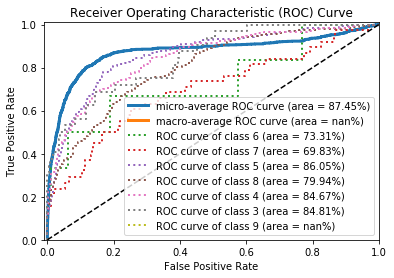

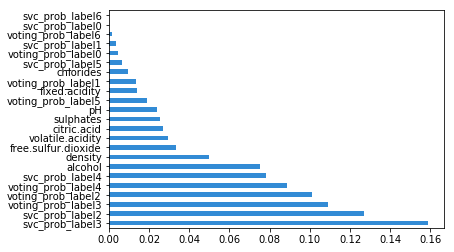

In [17]:
results = mm.get_results(LR
                         , 'LR', X_test, y_test, target_labels = y.unique(), target_names=[str(x) for x in y.unique()], reasume=True)

In [18]:
results = mm.get_results(svc
                         , 'svc', X_test, y_test, target_labels = y.unique(),
                         target_names=[str(x) for x in y.unique()],
                         results=results,reasume=False)

ValueError: operands could not be broadcast together with shapes (1100,23) (16,) (1100,23) 

Model Performance metrics:
------------------------------
Accuracy:  66.09% 
Precision: 67.69% 
Recall:    66.09% 
F1 Score:  64.26% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           6       0.63      0.77      0.69       473
           7       0.69      0.46      0.55       200
           5       0.69      0.74      0.71       351
           8       0.91      0.31      0.47        32
           4       1.00      0.05      0.10        38
           3       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         0

   micro avg       0.66      0.66      0.66      1100
   macro avg       0.56      0.33      0.36      1100
weighted avg       0.68      0.66      0.64      1100


Prediction Confusion Matrix:
------------------------------
          Predicted:                      
                   6   7    5   8  4  3  9
Actual: 6        364  27   82   0  0  0  0
        7        1

/Users/Zi/anaconda3/envs/jupyter-env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Zi/anaconda3/envs/jupyter-env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Zi/anaconda3/envs/jupyter-env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Zi/anaconda3/envs/jupyter-env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samp

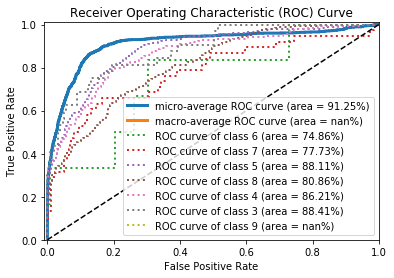

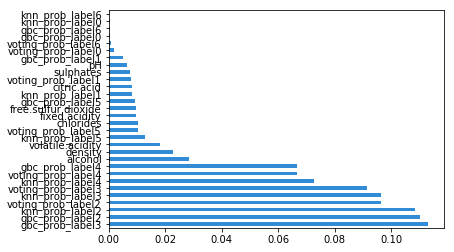

In [84]:
results = mm.get_results(lr
                         , 'lr', X_test, y_test, target_labels = y.unique(), target_names=[str(x) for x in y.unique()], reasume=True)

In [19]:
df = pd.read_csv('../data/wine_test.csv')

In [20]:
del df['type']

In [21]:
ss = StandardScaler()
df = pd.DataFrame(columns=df.columns,data=ss.fit_transform(df))

In [22]:
df.drop(['total.sulfur.dioxide','residual.sugar'], axis=1, inplace=True) # alcholと相関が強いので除外してみる

In [23]:
df_data = mm.add_predict_prob(est_dict=est_dict,df=df)

In [24]:
df_data = mm.add_predict_prob(est_dict=est_dict2,df=df_data)

In [34]:
ans_LR = pd.DataFrame(LR.predict(df_data), columns=['predict'])

ans_review_LR = pd.DataFrame(ans_LR['predict'].value_counts())

ans_review_LR['per'] = ans_review_LR['predict'] / 1000

In [35]:
ans_review_LR

,predict,per
6,582,0.582
5,402,0.402
7,14,0.014
8,1,0.001
4,1,0.001


In [31]:
df_res = pd.merge(pd.read_csv('../data/wine_test.csv'), ans_LR, left_index=True, right_index=True)

In [33]:
df_res.to_csv('../data/result.csv')

In [95]:
ans_lr = pd.DataFrame(svc.predict(df_data), columns=['predict'])

ans_review_lr = pd.DataFrame(ans_lr['predict'].value_counts())

ans_review_lr['per'] = ans_review_lr['predict'] / 1000

In [ ]:
ans

In [96]:
ans_review_lr

,predict,per
6,583,0.583
5,403,0.403
7,11,0.011
8,1,0.001
4,1,0.001
3,1,0.001


In [67]:
ans_voting = pd.DataFrame(voting.predict(df), columns=['predict'])

ans_review_voting = pd.DataFrame(ans_voting['predict'].value_counts())

ans_review_voting['per'] = ans_review_voting['predict'] / 1000

In [68]:
ans_review_voting

,predict,per
6,600,0.600
5,389,0.389
7,8,0.008
8,1,0.001
4,1,0.001
3,1,0.001


In [68]:
base = pd.DataFrame(df_train_data['quality'].value_counts())

In [69]:
base['per']=base['quality']/len(df_train_data)

In [70]:
base

,quality,per
6,2410,0.438421
5,1793,0.326178
7,910,0.165545
4,184,0.033473
8,170,0.030926
3,25,0.004548
9,5,0.000910
